A/B experiment evaluation using the standard tests

Hypothesis. ML team advised that the recommendations are making posts more interesting. Our ML team has created two new predicitive models on suggesting what posts the user might like. The first model is based on the posts user liked in the past and the second model is based on the posted that users similar to our user liked. We are checking the second model - recommendations are based on the posted that users similar to our user liked. We will use the CTR metric to decide if the new system should be deployed to production or not.

In [18]:
# Importing the libraries
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
%matplotlib inline

In [19]:
connection = {
    'host': HOST ,
    'password' : PWD ,
    'user' : 'student' ,
    'database' : DB 
    }

Extracting the data from DB: control group - group1, test group - group 2

In [20]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-06-13' and toDate(time) <= '2022-06-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [21]:
df = ph.read_clickhouse(q, connection=connection)

In [22]:
df.groupby('exp_group')['user_id'].count()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

Comparing the CTR distributions graphs visually

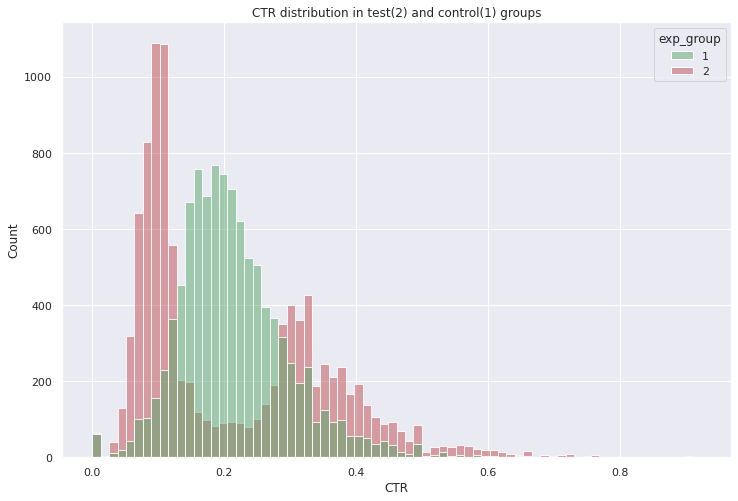

In [23]:
sns.set(rc={'figure.figsize':(12,8)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['g', 'r'],
              alpha=0.5,
              kde=False)
plt.title('CTR distribution in test(2) and control(1) groups')
plt.xlabel('CTR')
plt.show()

We can see from the graphs that CTR is lower in group 2 comparing to group 1. Let's compare the groups using statistical tests.

t-тест Стьюдента

In [24]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

P-value that we got by running the Students' t-test is over 0.05, thus, the difference between the groups means is not statistically significant. Student's t-test is telling us that the groups are similar, but the result is false positive actually, as the condition for applying Student's t-test is that distributions should be normal, but we can see that group 2 distribution is different from normal one. Let's run one more test.

Mann-Whitney test

In [25]:
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr))

print('The difference is not detected')
                   
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% cases A > B. Should be around 50%')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)
The difference is not detected
In 56.91 % cases A > B. Should be around 50%


Let's run one more test.

Nonparametric bootstrap

In [26]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [27]:
df = ph.read_clickhouse(q, connection=connection)

In [28]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [29]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

Creating the graphs for groups CTR distribution

<AxesSubplot:ylabel='Count'>

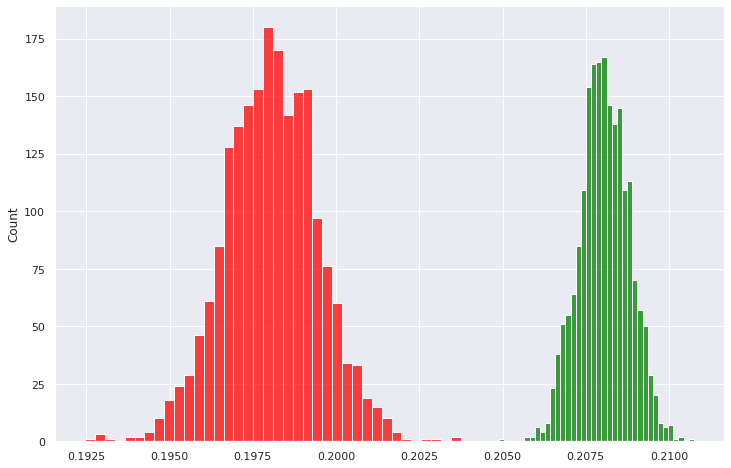

In [31]:
sns.histplot(data=ctr1, color='green')
sns.histplot(data=ctr2, color='red')

Creating the graph for the difference in groups CTR

<AxesSubplot:ylabel='Count'>

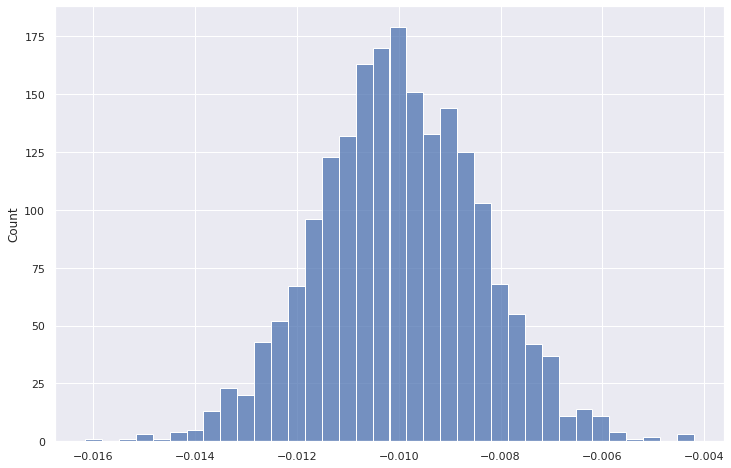

In [32]:
sns.histplot(ctr2 - ctr1)

The groups CTR difference value is negative, as test group CTR is lower than the control group CTR.

Extracting the data for the users with CTR over 0.5 for the control and test groups.

In [33]:
q1 = """
(SELECT * 
FROM
(SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-06-13' and toDate(time) <= '2022-06-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id)
WHERE ctr>0.5
GROUP BY exp_group, user_id,likes, views, ctr)
"""

In [34]:
df = ph.read_clickhouse(q, connection=connection)

In [35]:
df.groupby('exp_group')['user_id'].count()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

Conclusion.
The experiement proved that the new recommendtion system is worse than the one that is being currently used, as CTR values in test group are generally lower than CTR in the control group. It is not recommended to deploy the new recommendation system algorithm to production as it can lead to users leaving our service.
The new recommendation algorithms that we tested is based on suggesting the posts to the user based on the posted that the users similar to our user liked. Maybe the problem with this new algorithm was that it did not calculate ‘likeliness’ of the user groups correctly, so it makes sense to change the parameters the ‘likeliness’ is based on and run one more experiment to see if the results are better. We noticed a very interesting point: CTR in test group was generally lower than CTR in the control group, however, the number of users with CTR over 0.5 was higher in the test group comparing to the same metric in control group. CTR was over 0.5 for 309 users from the test group, while we saw CTR over 0.5 for only 61 users in the control group. This calculation means that the new algorithm works better for a subgroup of users and it is advised to dig deeper to see what characteristics these users have in common, so the new algorithm indeed works for them better as the ’likeliness’ is detected better for this subgroup. 
